# Fun with Neural Nets

---
#### Tensor & Keras Dense NN
#### Tensor & Keras CNNs

Below is a sorta tutoral for building a neural network to recognize handwritten digits.  The data is from Kaggle!!

1. Load the training data (`train.csv`) from Kaggle
2. Setup X and y (feature matrix and target vector)
3. Split X and y into train and test subsets.
4. Preprocess your data

   - NNs need values between 0-1 so we need to divide our `X` by the max value of a pixel (255).
   - Lucky us, we dont need to use a standard scalar we can just divide by 255
   - Since this is a multiclass classification problem, our NN needs our target `y` to be one-hot encoded
   
5. Create your network.

   - Remember that for multi-class classification you need a softamx activation function on the output layer, so they all sum up to 1.

6. Trian your network.
7. add hidden layers, adding hidden layer units, chaning the activation functions on the hidden layers, have fun.
8. Load in Kaggle's `test.csv`
9. Create your predictions (these should be numbers in the range 0-9).
10. Save your predictions and submit them to Kaggle.

# TensorFlow Dense

## Imports

In [1]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import pandas as pd
import numpy as np

/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Variable Assignment & Preprocessing

In [4]:
train = pd.read_csv('./train.csv')
X_target = pd.read_csv('./test.csv')

y = train['label']
X = train.drop('label',axis=1)

#one hot encoding those values
y = pd.get_dummies(y).values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [6]:
ss= StandardScaler()
ss.fit(X_train)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [7]:
X_target = ss.transform(X_target)

Text(0.5,1,'28x28 data')

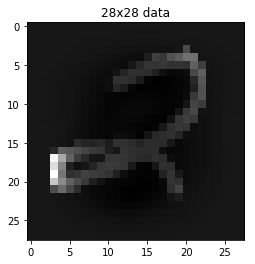

In [10]:
fig, ax = plt.subplots()
ax.imshow(X_train[4].reshape(28,28), cmap='gray')
ax.set_title('28x28 data')

## Model Building

In [11]:
tf.reset_default_graph()

In [12]:
# create "placeholders" for out X matrix and y target
X = tf.placeholder(dtype=tf.float32,
                   shape=(None,X_train.shape[1]),
                   name='X')

y = tf.placeholder(dtype=tf.float32,
                   shape=(None),
                   name='y')

In [13]:
# Defined our network topology!!
n_hidden = 12
n_hidden2 = 10

hidden1 = tf.layers.dense(X, units=n_hidden,
                          name='hidden1',
                          activation=tf.nn.relu)

hidden2 = tf.layers.dense(hidden1, units=n_hidden2,
                          name='hidden2',
                          activation=tf.nn.tanh)

y_hat = tf.layers.dense(hidden2,    
                        units=y_train.shape[1],
                        activation=tf.nn.softmax,
                        name='y_hat')

In [14]:
# Setup Loss&Learning
loss = tf.losses.softmax_cross_entropy(y, y_hat)

learning_rate = 0.1
optimizer = tf.train.AdamOptimizer(learning_rate)

training_op = optimizer.minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



## Model Run & Interpretation

In [15]:
init = tf.global_variables_initializer()

In [16]:
train_err = []
test_err = []

with tf.Session() as sess:
    init.run()
    
    for epoch in range(15):
        sess.run(training_op,
                 feed_dict={X:X_train, y:y_train})
        train_loss = sess.run(loss, 
                              feed_dict={X:X_train, y:y_train})
        test_loss = sess.run(loss,
                             feed_dict={X:X_test, 
                                        y:y_test})
        train_err.append(train_loss)
        test_err.append(test_loss)
        
        if epoch%5==0:
            print('epoch',epoch,train_loss,test_loss)
        if test_loss/train_loss>1.02:
            print('nope')
            break
                
    pred = sess.run(y_hat, feed_dict={X:X_test})
    target_pred = sess.run(y_hat, feed_dict={X:X_target})

epoch 0 2.2457066 2.2477427
epoch 5 1.8900692 1.8957309
epoch 10 1.7365327 1.7419295


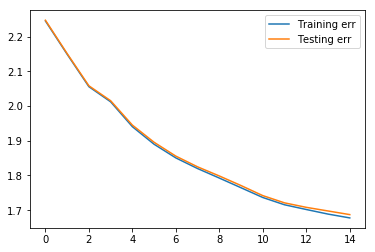

In [17]:
plt.plot(train_err, label='Training err')
plt.plot(test_err, label='Testing err')
plt.legend();

In [18]:
#target pred is the validation for which we do not have labels
#pred is our preds from our test split
target_pred = [np.argmax(x) for x in target_pred]
pred = [np.argmax(x) for x in pred]

In [19]:
metrics.confusion_matrix(np.argmax(y_test,axis=1),pred)

array([[ 951,    0,   21,    5,    8,    0,    9,   11,   12,    4],
       [   0, 1085,   10,    5,    0,    0,    6,    3,   33,    6],
       [  18,    5,  875,   30,   18,    0,   37,   14,   26,    3],
       [  11,   12,   94,  873,   14,    0,    4,   17,   20,   19],
       [   6,   20,    8,    6,  847,    0,    6,    4,   12,  117],
       [  93,   37,  133,  197,   60,    0,   58,   37,  288,   42],
       [  26,   13,   16,    1,   25,    0,  964,    1,    9,    0],
       [   0,    9,   10,   16,   22,    0,    0,  990,    1,   80],
       [   6,   53,   31,   58,   17,    0,   25,   26,  802,   21],
       [   8,    9,    0,   26,   86,    0,    0,   36,    5,  878]])

In [20]:
metrics.accuracy_score(np.argmax(y_test,axis=1),pred)

0.7871428571428571

# Dense NN Keras

In [21]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras import regularizers, optimizers

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [22]:
Training = pd.read_csv('./train.csv')
Validation = pd.read_csv('./test.csv')

In [23]:
#train test split with one hot encoded y's
X_train,X_test,y_train,y_test = train_test_split(Training.drop('label',axis=1),to_categorical(Training.label))

In [24]:
#mm = MinMaxScaler()
#X_train = mm.fit_transform(X_train)
#X_test = mm.transform(X_test)

X_train = X_train/255.0
X_test = X_test/255.0

In [25]:
#if we want to adjust the learning rate - the difference per steps
#if we want to add regularization to avoid fitting issues
adam = optimizers.Adam(lr=0.01)
l2 = regularizers.l2(0.0001)

In [26]:
model = Sequential()

n_input = X_train.shape[1]
n_hidden = 256
n_output = y_train.shape[1]

#here we gen the topology
model.add(Dense(n_hidden,input_dim=n_input,
                activation='sigmoid',kernel_regularizer = l2))
model.add(Dropout(.8))
model.add(Dense(n_hidden,input_dim=n_input,
                activation='sigmoid',kernel_regularizer = l2))
model.add(Dense(n_output, 
                activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=adam)

#here we add early stopping so we can stop once 
#we are overfitting to the training data
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
callbacks_list = [early_stop]

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=100, 
                    batch_size=128, callbacks=callbacks_list, verbose =0)

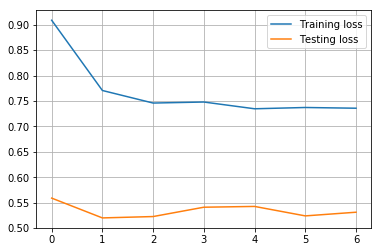

In [27]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.xticks(history.epoch)
plt.grid()
plt.legend()

In [28]:
#we want to keep our testing loss as low as possible.
#if it does not converge, that means... 
# not enough epochs, too much regularization, complexity, a whole slew of reasons
#... biggest of all is likely because dense NN are not great for images
# thats what CNNs are for

In [29]:
metrics.confusion_matrix(np.argmax(y_test,axis=1),model.predict_classes(X_test))

array([[1028,    0,    0,    0,    3,    1,   13,    0,    2,    1],
       [   0, 1175,    2,    1,    4,    3,    2,    3,    5,    0],
       [  10,   10,  916,    2,   23,    1,   18,   21,   10,    1],
       [   6,   11,   41,  951,    0,   57,    2,    7,   15,   14],
       [   1,    3,    4,    0, 1024,    0,    9,    1,    2,   10],
       [   8,    8,    1,    6,   11,  882,   30,    4,    3,    6],
       [   8,    2,    0,    0,    7,    4,  997,    0,    0,    0],
       [   1,   10,    9,    0,   10,    1,    1, 1046,    2,   13],
       [   8,   15,    6,   12,   11,   20,   30,    3,  844,   32],
       [   9,    4,    1,   11,  104,    6,    1,   25,    4,  871]])

In [30]:
metrics.accuracy_score(np.argmax(y_test,axis=1),model.predict_classes(X_test))

0.927047619047619

In [31]:
#loss: 0.6971 - val_loss: 0.4636 @ adam = .01, l2=0.0001, nhid = 128, 2 layers - met.acc = 0.932
#loss: 0.9854 - val_loss: 0.6270 @ adam = .01, l2=0.0001, nhid = 128, 3 layers - met.acc = 0.909
#loss: 0.6683 - val_loss: 0.4834 @ adam = .01, l2=0.0001, nhid = 256, 2 layers - met.acc = 0.935
#loss: 0.9721 - val_loss: 0.7077 @ adam = .01, l2=0.0001, nhid = 256, 3 layers - met.acc = 0.919

# Keras CNN

In [32]:
# 1. Import libraries and modules
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(123)  # for reproducibility

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import regularizers, optimizers
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from keras.callbacks import EarlyStopping
 
# 2. Load pre-shuffled MNIST data into train and test sets
train = pd.read_csv('./train.csv')
X_target = pd.read_csv('./test.csv')

y = train['label']
X = train.drop('label',axis=1)

#One Hot Encoded Targets
y = pd.get_dummies(y).values

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X.values,y,test_size=(0.2))

In [59]:
#if i want to use the entire mnist dataset
#kaggle added some but not all
#(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [60]:
#preprocess input data
X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_test = X_test.reshape(X_test.shape[0],28,28,1)
      
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

In [62]:
adam = optimizers.Adam(lr=0.01)
l2 = regularizers.l2(0.1)

In [63]:
# Model topology & building
model = Sequential()

In [64]:
model.add(Convolution2D(filters = 6, 
                        kernel_size = 3,
                       activation = 'relu', 
                        input_shape = (28,28,1),
                       padding = 'same'))
model.add(MaxPooling2D( pool_size= (2,2)))
model.add(Dropout(0.3))

In [65]:
model.add(Convolution2D(filters = 6, 
                        kernel_size = 3,
                       activation = 'relu',
                       padding = 'same'))
model.add(MaxPooling2D( pool_size= (2,2)))
model.add(Flatten())
model.add(Dropout(0.5))

In [66]:
model.add(Dense(528, 
                activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(256, 
                activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(128, 
                activation='relu'))

In [67]:
model.add(Dense(10, 
                activation='softmax'))

In [68]:
#COMPILE
model.compile(loss = 'categorical_crossentropy',
              metrics=['accuracy'],
             optimizer = adam)

early_stop = EarlyStopping(monitor='val_loss', min_delta=1, patience=10)

callbacks_list = [early_stop]

In [69]:
# 7. Fit model on training data
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, 
                    batch_size=256,  verbose =1)

Train on 33600 samples, validate on 8400 samples
Epoch 1/50
33600/33600 [==============================] - 58s 2ms/step - loss: 0.6229 - acc: 0.7962 - val_loss: 0.1498 - val_acc: 0.9582
Epoch 2/50
33600/33600 [==============================] - 44s 1ms/step - loss: 0.3366 - acc: 0.8955 - val_loss: 0.1322 - val_acc: 0.9632
Epoch 3/50
33600/33600 [==============================] - 51s 2ms/step - loss: 0.3147 - acc: 0.9039 - val_loss: 0.1371 - val_acc: 0.9630
Epoch 4/50
33600/33600 [==============================] - 51s 2ms/step - loss: 0.2981 - acc: 0.9094 - val_loss: 0.1173 - val_acc: 0.9681
Epoch 5/50
33600/33600 [==============================] - 46s 1ms/step - loss: 0.2783 - acc: 0.9163 - val_loss: 0.1084 - val_acc: 0.9707
Epoch 6/50
33600/33600 [==============================] - 33s 991us/step - loss: 0.2685 - acc: 0.9194 - val_loss: 0.1190 - val_acc: 0.9677
Epoch 7/50
33600/33600 [==============================] - 42s 1ms/step - loss: 0.2577 - acc: 0.9232 - val_loss: 0.1080 - val_ac

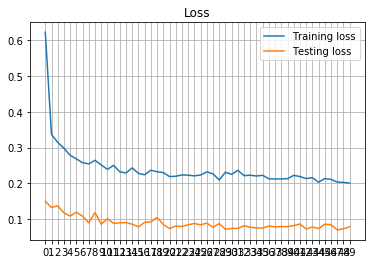

In [70]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.xticks(history.epoch)
plt.title('Loss')
plt.grid()
plt.legend();

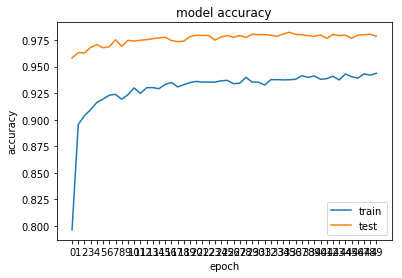

In [71]:
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(history.epoch)
plt.xlim()
plt.legend(['train', 'test'], loc='best')
plt.show();

In [78]:
confusion_matrix(np.argmax(y_test,axis=1),model.predict_classes(X_test))

array([[809,   0,   0,   0,   0,   0,   2,   0,   0,   2],
       [  0, 913,   5,   0,   2,   0,   1,   1,   3,   2],
       [  1,   1, 834,   3,   0,   0,   0,   4,   7,   2],
       [  0,   0,   2, 817,   0,   1,   1,   1,  12,   9],
       [  0,   0,   0,   0, 824,   0,   3,   0,   2,  16],
       [  2,   0,   0,   2,   0, 730,   5,   0,   5,   6],
       [  1,   0,   1,   1,   0,   0, 854,   0,   6,   0],
       [  0,   3,   5,   2,   1,   0,   0, 854,   3,   8],
       [  1,   5,   3,   1,   1,   3,   4,   4, 769,   7],
       [  1,   1,   0,   0,   4,   0,   0,   6,   5, 816]])

In [79]:
accuracy_score(np.argmax(y_test,axis=1),model.predict_classes(X_test))

0.9785714285714285

In [ ]:
#|0.9235| loss: 1.0872 - val_loss: 0.4303 @ adam = .01, 2convo - d - hid(128) - d - out
#|bad   | loss: bad - val_loss: bad @ adam = .01, 2convo - d - hid(128)(l2=0.001) - d - hid2(128) - out

#|0.9235| loss: 1.0872 - val_loss: 0.4303 @ adam = .01, 2convo - hid(128) - d - hid2(128) - d - out
#|0.9556| loss: 0.5472 - val_loss: 0.1765 @ adam = .01, 2convo - hid(128) - d - hid2(128) - d - hid3(128) - out

#|0.9812| loss: 0.1270 - val_loss: 0.0645 @ 2convo - hid(128) - d(0.5) - hid(128) - d(0.5) - hid2(128) - out
#|0.9814| loss: 0.1216 - val_loss: 0.0775 @ 2convo - hid(256) - d(0.5) - hid(128) - d(0.5) - hid2(128) - out
#|0.9828| loss: 0.1230 - val_loss: 0.0627 @ 2convo - hid(256) - d(0.5) - hid(256) - d(0.5) - hid2(128) - out(5epoch)

#|0.9816| loss: 0.1051 - val_loss: 0.0680 @ 2convo - hid(256) - d(0.4) - hid(256) - d(0.4) - hid2(128) - out(5epoch)
#|0.9816| loss: 0.1005 - val_loss: 0.0630 @ 2convo - hid(256) - d(0.3) - hid(256) - d(0.4) - hid2(128) - out(4epoch)
#|0.9843| loss: 0.0751 - val_loss: 0.0627 @ 2convo - hid(256) - d(0.25) - hid(256) - d(0.3) - hid2(128) - out(7ish)

#|0.9825| loss: 0.1271 - val_loss: 0.0536 @ convo-d(0.25)-convo - hid(256) - d(0.25) - hid(256) - d(0.25) - hid2(128) - out()

# TensorFlow CNN

In [ ]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import pandas as pd
import numpy as np

In [ ]:
Training = pd.read_csv('./train.csv')
X_target = pd.read_csv('./test.csv')

In [ ]:
y = Training['label']
X = Training.drop('label',axis=1)
y = pd.get_dummies(y).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=(0.1))

In [39]:
# Min/Max Scaling
X_train = X_train.values/255.0
X_test = X_test.values/255.0

In [ ]:
# Parameters
img_size = 28
img_size_flat = img_size * img_size
n_labels = 10 #0-9

# 
lr = 0.01
n_nodes = 100
epochs = 10
stride = 5

In [90]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32,shape=[None,784])
y = tf.placeholder(tf.float32,shape=[None,10])
x_image = tf.reshape(x,[-1,28,28,1])

In [91]:
conv1 = tf.layers.conv2d(
    inputs=x_image,
    filters=32,
    kernel_size=[5, 5],
    padding="same",
    activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

In [92]:
conv2 = tf.layers.conv2d(
    inputs=x_image,
    filters=32,
    kernel_size=[5, 5],
    padding="same",
    activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=pool1, pool_size=[2, 2], strides=2)

In [93]:
pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

In [94]:
dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

In [95]:
dropout = tf.layers.dropout(inputs=dense, rate=0.4)

In [96]:
logits = tf.layers.dense(inputs=dropout, units=10)

In [97]:
#tf.argmax(input=logits, axis=1)

In [98]:
#tf.nn.softmax(logits, name="softmax_tensor")

In [99]:
predictions = {
    "classes": tf.argmax(input=logits, axis=1),
    "probabilities": tf.nn.softmax(logits, name="softmax_tensor")}

In [100]:
loss = tf.losses.softmax_cross_entropy(y, logits)

learning_rate = 0.1
optimizer = tf.train.AdamOptimizer(learning_rate)

In [101]:
training_op = optimizer.minimize(loss)

In [105]:

"""
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train},
    y=y_train,
    batch_size=100,
    num_epochs=10,
    shuffle=True)
"""

'\ntrain_input_fn = tf.estimator.inputs.numpy_input_fn(\n    x={"x": X_train},\n    y=y_train,\n    batch_size=100,\n    num_epochs=10,\n    shuffle=True)\n'

In [106]:

init = tf.global_variables_initializer()

train_err = []
test_err = []

with tf.Session() as sess:
    init.run()
    
    for epoch in range(15):
        sess.run(training_op,
                 feed_dict={X:X_train, y:y_train})
        train_loss = sess.run(loss, 
                              feed_dict={X:X_train, y:y_train})
        test_loss = sess.run(loss,
                             feed_dict={X:X_test, 
                                        y:y_test})
        train_err.append(train_loss)
        test_err.append(test_loss)
        
        if epoch%5==0:
            print('epoch',epoch,train_loss,test_loss)
        if test_loss/train_loss>1.02:
            print('nope')
            break
                
    pred = sess.run(y_hat, feed_dict={X:X_test})
    target_pred = sess.run(y_hat, feed_dict={X:X_target})

TypeError: 'DataFrame' objects are mutable, thus they cannot be hashed

In [81]:
y_train[0]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=uint8)